# AdaBoost Demo

# Importing Libraries

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Loading in the data

In [ ]:
dataset = datasets.make_moons(n_samples=200, noise=0.2)
dataX = dataset[0]
dataY = dataset[1]

# By default the dataset has labels 0 and 1
# We set 0 labels to -1 to be consistent with the Adaboost pseudocode we saw in lecture
dataY = np.where(dataY == 0, -1, 1)

trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.1)

# Decision Stumps

A decision tree with just one split, which divides the data into two classes based on just one feature. You can think of them as if statements like "if temperature > 70, park location = desert, otherwise park location = forest"

A single stump won't be a very effective classifier on its own, but boosting can train an ensemble of classifiers to be effective. You'll learn more about stumps and larger decision trees next lecture (lecture 10).

**Note:** This code works quite a bit differently from the decision tree code from homework 6, and isn't likely to be a helpful reference for the code portion of that assignment.

In [ ]:
class DecisionStump:
    def __init__(self, index_split_on):
        # The index split on is the feature that this stump will split the data on
        self.index_split_on = index_split_on
        # The threshold is the value the example is compared to
        self.threshold = 0
        # 0 mean less than, 1 means greater than than
        self.direction = 0

    def fit(self, X, Y, example_weights):
       best_threshold = 0
       best_direction = 0
       min_loss = np.inf

       # To fit the stump, we take a greedy approach and find the
       # threshold and direction that results in the least error
       for i in range(len(X)):
           for direction in [0, 1]:
              self.threshold = X[i][self.index_split_on]
              self.direction = direction
              cand_loss = self.weighted_loss(X, Y, example_weights)
              if cand_loss < min_loss:
                  min_loss = cand_loss
                  best_threshold = self.threshold
                  best_direction = self.direction
       self.threshold = best_threshold
       self.direction = best_direction

    # Prediction is made based on the feature, threshold, and inequality direction
    def predict(self, features):
        if (self.direction == 0):
            if (features[self.index_split_on] < self.threshold):
                return -1
            else:
                return 1
        else:
            if (features[self.index_split_on] > self.threshold):
                return -1
            else:
                return 1

    # Loss for our stumps is computed based on example weights:
    # examples weighted higher cause loss to increase more if the stump
    # classifies them incorrectly
    def weighted_loss(self, X, Y, example_weights):
        total = 0.0
        for i in range(len(X)):
            prediction = self.predict(X[i])
            if (prediction != Y[i]):
                total += example_weights[i]
        return total

# Adaboost Algorithm

In [ ]:
class Adaboost:
    def __init__(self, X, Y, T):
        # The set of weak learners (decision stumps) that make up the ensemble
        self.weak_learners = []

        # Adaboost uses two kinds of weights: the first is the example weights, weights
        # placed on each *example* in the training set that are greater the more the
        # current weak learner should focus on classifying it correctly
        self.example_weights = np.array([1 / len(X)] * len(X))

        # The second kind of weights are the influence weights, weights placed
        # on each *model* to control how much influence they have over the final prediction
        self.influence_weights = []

        # T = the number of weak learners we want in our ensemble
        self.T = T

        # For producing an animation later
        self.example_weights_history = []

        self.boost(X, Y)

    def boost(self, X, Y):
        for t in range(self.T):
            self.example_weights_history.append(self.example_weights)
            new_learner = None
            learner_loss = np.inf

            # Choose learner based on example weights, we perform ERM with the example_weights
            # on a decision stump for each feature, and pick the stump with the lowest error
            for split_index in range(len(X[0])):
                cand_learner = DecisionStump(split_index)
                cand_learner.fit(X, Y, self.example_weights)
                cand_loss = cand_learner.weighted_loss(X, Y, self.example_weights)
                if cand_loss < learner_loss:
                    learner_loss = cand_loss
                    new_learner = cand_learner

            # Add the new learner to the collection of weak learners, and
            # calculate its influence based on its error
            learner_weight = 0.5 * np.log((1 / learner_loss) - 1)
            self.weak_learners.append(new_learner)
            self.influence_weights.append(learner_weight)

            # Update example weights for next iteration, based on which
            # examples our newest learner got wrong
            new_example_weights = []
            for i in range(len(X)):
                pred_i = new_learner.predict(X[i])
                new_example_weights.append(self.example_weights[i] * np.exp(-1 * learner_weight * Y[i] * pred_i))
            new_example_weights = np.array(new_example_weights)
            new_example_weights /= np.sum(new_example_weights)

            self.example_weights = new_example_weights

    def predict(self, features, num_learners):

        # Predictions are made by combining those of the learners,
        # with learners with more influence having more weight in the
        # final prediction.

        pred_sum = 0
        for t in range(num_learners):
            pred_sum += self.influence_weights[t] * self.weak_learners[t].predict(features)
        if pred_sum < 0:
            return -1
        return 1

    def predict_array(self, array, num_learners):
        output = []
        for i in range(len(array)):
            output.append(self.predict(array[i], num_learners))
        return np.array(output)

    def loss(self, X, Y):
        cnt = 0.0

        for i in range(len(X)):
            prediction = self.predict(X[i], self.T)
            if (prediction != Y[i]):
                cnt += 1.0
        return cnt/len(X)

Evaluate

In [ ]:
single_stump = Adaboost(trainX, trainY, 1)
print("Single stump train set loss:", single_stump.loss(trainX, trainY))
print("Single stump test set loss:", single_stump.loss(testX, testY))

stumps_boosted = Adaboost(trainX, trainY, 9)
print("Boosted ensemble train set loss:", stumps_boosted.loss(trainX, trainY))
print("Boosted ensemble test set loss:",stumps_boosted.loss(testX, testY))

Single stump train set loss: 0.17222222222222222
Single stump test set loss: 0.05
Boosted ensemble train set loss: 0.03888888888888889
Boosted ensemble test set loss: 0.05


# Producing an Animation
(feel free to ignore this code)

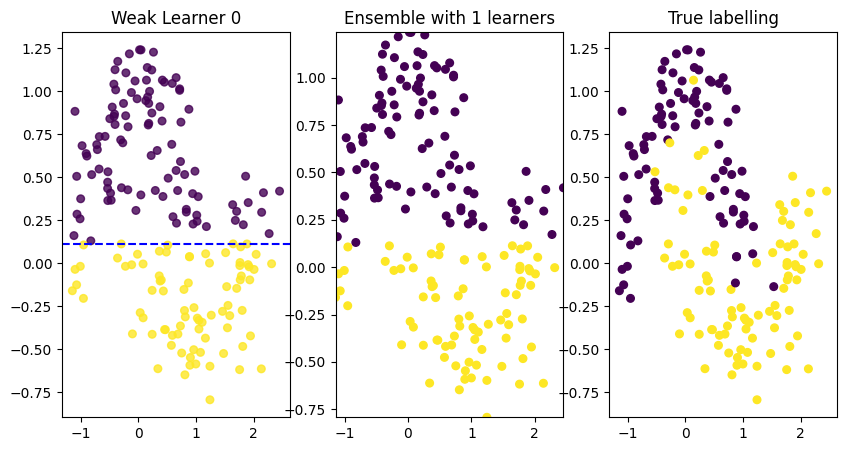

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

def plot_decision_boundary(ax, clf, X, Y, t, ensemble_preds):
    ax.scatter(X[:, 0], X[:, 1], s=30, c=ensemble_preds)
    X1s = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    X2s = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(X1s, X2s)
    X_test = np.c_[X1.ravel(), X2.ravel()]
    Y_pred = clf.predict_array(X_test, t+1).reshape(X1.shape)
    ax.contour(X1, X2, Y_pred, colors = ['b'], linestyles = ['--'], levels=[1])
    return ax

def get_animation_object(ensemble, X, Y):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    def animate(t):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax1.set_title("Weak Learner " + str(t))
        ax2.set_title("Ensemble with " + str(t+1) + " learners")
        ax3.set_title("True labelling")

        current_learner_preds = []
        current_learner = ensemble.weak_learners[t]
        for i in range(len(X)):
            current_learner_preds.append(current_learner.predict(X[i]))
        if (current_learner.index_split_on == 0):
            ax1.axvline(x = current_learner.threshold, color = 'b', linestyle = '--')
        else:
            ax1.axhline(y = current_learner.threshold, color = 'b', linestyle = '--')
        ensemble_preds = ensemble.predict_array(X, t+1)
        return ax1.scatter(X[:, 0], X[:, 1], s=30 * len(X) * ensemble.example_weights_history[t], c=current_learner_preds, alpha=0.8), plot_decision_boundary(ax2, ensemble, X, Y, t, ensemble_preds), ax3.scatter(X[:, 0], X[:, 1], s=30, c=Y)

    ani = FuncAnimation(fig, animate, frames=ensemble.T, interval=500, repeat=True)
    return ani

ani = get_animation_object(stumps_boosted, trainX, trainY)
ani